# Density of states from semiclassical and exact calculations for the inplane field configuration

In this notebook we show how to calculate the density of states both in the semiclassical approach and from the numerical exact solution.

In [1]:
%pylab inline
#plt.style.use('dark_background')
import tqdm
from scipy.special import ellipk,ellipe
from scipy.optimize import *
from scipy import signal
import pickle

Populating the interactive namespace from numpy and matplotlib


## Semiclassics

In order to obtain the DOS at a given energy we need to find the allowed $p_x$-s at that energy and calculate the group velocity as well. 
For this task we need to use a root finding algorithm to find the required momenta from the implicit equations. First let us define the necessary functions which define the spectrum.

In [2]:
# Helper functions for finding the trivial part of the spectrum
def Ftri(a,e):
    return sqrt(e)*(  2*a*ellipe((a+e)/(2*e))
                   +(e-a)*ellipk((a+e)/(2*e))
                   )

ftri = lambda pp,ee,nn,BB : (Ftri((1-pp**2)/BB**(2/3),ee/BB**(2/3))
                           -3*pi/(2*sqrt(2))*(nn+1/2) )


dostri= lambda pp,ee: (2*pp-4*pp*ellipe((1+ee-pp**2)/(2*ee))/
                       ellipk((1+ee-pp**2)/(2*ee)))**(-1)

# Helper functions for finding the topological part of the spectrum
def Ftop(a,e):
    return sqrt(a+e)*(    a*ellipe((2*e)/(a+e))
                     +(e-a)*ellipk((2*e)/(a+e))
                     )

ftop  = lambda pp,ee,nn,BB : (Ftop((1-pp**2)/BB**(2/3),ee/BB**(2/3))
                           -3*pi/2*nn )

dostop= lambda pp,ee: ee/(2*pp*(1-pp**2+((-1-ee+pp**2)*ellipe((2*ee)/(1+ee-pp**2)))/
                                ellipk((2*ee)/(1+ee-pp**2)) ))

The DOS in  semi-onedimensional systems at a given energy is given by the reciprocals of the magnitude of group velocities for allowed momenta.
$$\varrho(E)=\sum_i\left (\frac{1}{|\partial_pE(p_i)|}\right)_{E(p_i)=E} $$
Thus we need to find the at a given energy the allowed momenta and the corresponding velocities.
As a reminder if a function $E(p)$ is defined via the implicit relation $$ F(p,E(p))=0 $$ then its derivative is expressed as $$\partial_pE=-\frac{\partial_pF}{\partial_EF}  $$

In [3]:
B=1/20
Eran=linspace(0.,1.,200)

In [4]:
DOS_top=[]
DOS_tri=[]
spectr_top=[]
spectr_tri=[]

for e in tqdm.tqdm_notebook(Eran):
    dat=[]
    if e<1.:
        for n in range(1,70):
            try:
                # bisect seems to do the job here 
                # we just have to keep away from 
                # the boundary between the two regions
                val=bisect(ftop,0,sqrt(1-e)-1e-6,args=(e,n,B))               
                dat.append(abs(dostop(val,e)))
                spectr_top.append([e,val])
            except:
                pass
    DOS_top.append(sum(dat))
    dat=[]
    for n in range(70):
        try:
            # here root proved to be a better alternative
            # we need to be carefull since we have 
            # potentially two states at a given energy
            val=root(ftri,3,args=(e,n,B))
            if val['success']:
                dat.append(abs(dostri(val.x,e)))
                spectr_tri.append([e,val.x])
            if n>0:
                val=root(ftri,sqrt(1-e)+1e-2,args=(e,n,B))
                if val['success']:
                    dat.append(abs(dostri(val.x,e)))
                    spectr_tri.append([e,val.x])

        except:
            pass
    DOS_tri.append(sum(dat))

DOS_top=array(DOS_top)
DOS_tri=array(DOS_tri)
spectr_tri=array(spectr_tri)
spectr_top=array(spectr_top)

HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


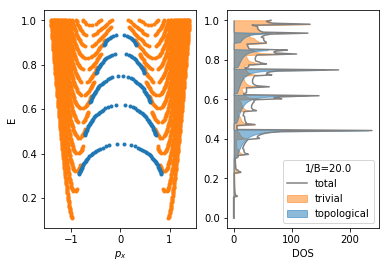

In [5]:

subplot(121)
plot(spectr_tri[:,1],spectr_tri[:,0],'C1.')
plot(-spectr_tri[:,1],spectr_tri[:,0],'C1.')
plot(spectr_top[:,1],spectr_top[:,0],'C0.')
plot(-spectr_top[:,1],spectr_top[:,0],'C0.')
xlabel('$p_x$')
ylabel('E')

subplot(122)
fill_betweenx(Eran,2*DOS_tri,color='C1',alpha=0.5,label='trivial') 
fill_betweenx(Eran,4*DOS_top,color='C0',alpha=0.5,label='topological')
plot(2*(DOS_tri+2*DOS_top),Eran,'gray',label='total')
legend(title='1/B='+str(1/B))
xlabel('DOS')

## Exact diagonalization

Here we do the same as we did in the semiclassical approach, namely we recast our original eigen problem for finding energies to one for finding the allowed momenta. 


The Hamiltonian we consider for nodal loop semi metals has the form
\begin{equation}
\hat{H}  =\left(\Delta-\frac{p_{x}^{2}+\left(p_{y}+eB_{0}z\right)^{2}}{2m}\right)\sigma_{x}+v\hat{p}_{z}\sigma_{z},
\end{equation}
which can be recast in dimensionless form by rescaling position and momentum in the $z$ direction by introducing $\hat{\lambda}$ and the corresponding momentum $\hat{p}_{\lambda}$
\begin{align}
\hat{H}& =E_{0}\left[\left(\frac{\Delta}{E_{0}}-\frac{p_{x}^{2}}{2mE_{0}}-\hat{\lambda}^{2}\right)\sigma_{x}+\hat{p}_{\lambda}\sigma_{z}\right],\\
E_{0} & =\left(eBv/\sqrt{2m}\right)^{\frac{2}{3}}.
\end{align}

The corresponding eigen equation for the energy $E$ can be recast for an eigen equation for $p_x^2$ 

\begin{align}
E_{0}\left[\left(\frac{\Delta}{E_{0}}-\frac{p_{x}^{2}}{2mE_{0}}-\hat{\lambda}^{2}\right)\sigma_{x}+\hat{p}_{\lambda}\sigma_{z}\right]\left|\psi\right\rangle  & =E\left|\psi\right\rangle \\
\left[\left(\frac{\Delta}{E_{0}}-\hat{\lambda}^{2}\right)\sigma_{0}-\text{i}\hat{p}_{\lambda}\sigma_{y}-E\sigma_{x}\right]\left|\psi\right\rangle  & =\frac{p_{x}^{2}}{2mE_{0}}\left|\psi\right\rangle 
\end{align}

Once we obtain the allowed $p_x$-es at a given energy $E$ the groupvelocity $\partial_{p_x}E$ necessary for the evaluation of the DOS is given by 
\begin{equation}
\partial_{p_x}E=-\left\langle \psi\right|\frac{p_{x}}{m}\left|\psi\right\rangle. 
\end{equation}


In [6]:
# using sparse matrix routines 
import scipy.sparse as ss
import scipy.sparse.linalg as sl

In the code cell below we define the discretization of the neccessary operators used in the differential eigen problem.

In [7]:
dim=600 
lmd=linspace(-10,10,dim)  # diagonal elements of the lambda operator
dlmd=(max(lmd)-min(lmd))/dim
# pauli matrices
sx=array([[0,1],
         [1,0]])
sz=array([[1,0],
         [0,-1]])
sy=array([[0,-1j],
         [1j,0]])
# momentum operator 
ps=1j*(ss.diags([ones(dim-1)],[1])-ss.diags([ones(dim-1)],[-1]))/(2*dlmd)

ons=ones_like(lmd) # just a helper array

The code cell below defines the function that generates the differential operator.

In [8]:
# function for building the matrix for a given energy and magnetic field
makeEB=(lambda ee,BB: (
    -ss.kron(ss.diags([lmd**2*BB**(2/3)],[0]),eye(2))
    +ss.kron(ss.diags([ons],[0]),eye(2))
    -ee*ss.kron(ss.diags([ons],[0]),sx)
    -BB**(2/3)*1j*ss.kron(ps,sy)
    ).tocsc() )
# matrix to be used in evaluationg the group velocity
curr=ss.kron(ss.diags([ons],[0]),sx)

The cell below generates data for the exact DOS. It runs a bit to long (10-20 minutes depending on hardware). The calculated data is duped in the data folder. If you want to run the calculation your selfe uncomment the cell and by all means do run it! Otherwise just use the data provided. 

In [9]:
#datE=[]
#for eee in tqdm.tqdm_notebook(linspace(0.001,1.,200)):
#    va,ve=sl.eigs(makeEB(eee,B),k=150,sigma=0,return_eigenvectors=True)
#    vg=[]
#    for i in range(len(va)):
#        vvee=ve[:,i]
#        vvaa=va[i]
        
#        vg.append(dot(conj(vvee),-2*sqrt(vvaa)*curr*vvee))
#    vg=array(vg)
#    idx=(abs(imag(va))<1e-10)*(real(va)>0)   
#    datE.append(dict(E=eee,va=va,vg=vg,dos=sum(1/abs(vg[idx]))))

# Dump data and meta data in output file
#with open('data/exact_E_scan_B_1_over_20', 'wb') as handle:
#    pickle.dump(datE , handle, protocol=pickle.HIGHEST_PROTOCOL)

Now we can plot the calculated exact spectrum and DOS

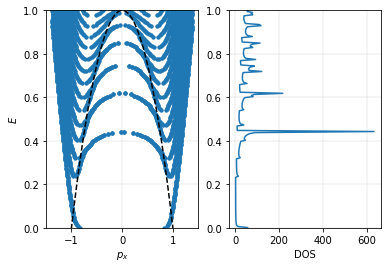

In [10]:
with open('data/exact_E_scan_B_1_over_20','br') as file:
        datE=pickle.load(file)
spectr_exact=hstack([ array([d['E']*ones_like(d['va']),d['va'],d['vg']]) for d in datE ]).T;
idx=(abs(imag(spectr_exact[:,1]))<1e-10)*(real(spectr_exact[:,1])>0)
t=linspace(-2,2,314)
subplot(121)
plot(real(sqrt(spectr_exact[idx,1])),real(spectr_exact[idx,0]),'C0.')
plot(-real(sqrt(spectr_exact[idx,1])),real(spectr_exact[idx,0]),'C0.')
plot(t,1-t**2,'k--')
xlabel('$p_x$')
ylabel('$E$')
ylim(0,1.0)
xlim(-1.5,1.5)
grid(lw=0.25)
subplot(122)
dosdat=array([[d['E'],real(d['dos'])] for d in datE ])
plot(dosdat[:,1],dosdat[:,0])
ylim(0,1.0)
grid(lw=0.25)
xlabel('DOS');


As a comparison of the two methods let us plot the DOS calculated in the two approaches. As we can see the two are in a rather good agreement.

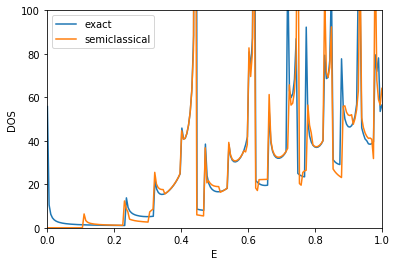

In [11]:
plot(dosdat[:,0],dosdat[:,1],label='exact')
plot(Eran,2*(DOS_tri+2*DOS_top),label='semiclassical')
legend()
xlabel('E')
ylabel('DOS')
xlim(0,1)
ylim(0,100);

## DOS in terms of 1/B

In this sectin we plot the calculated density of states in terms of $1/B$ as it is costum to do in experiments. 
We compare the semiclassical and exact calculations for two cases. We set a magnetic filed inervall for both cases the same, and change the energy (i.e. the chemical potential) at which the DOS is evaluated. In the first case the oscillations are dominated by the trivial part of the spectrum while in the later the topological spectrum gives the most contributions. 

In [12]:
DOS_topB=[]
DOS_triB=[]
e=0.117
Bran=1/linspace(10,200,200)
for B in tqdm.tqdm_notebook(Bran):
    dat=[]
    if e<1.:
        for n in range(1,70):
            try:
                # bisect seems to do the job here 
                # we just have to keep away from 
                # the boundary between the two regions
                val=bisect(ftop,0,sqrt(1-e)-1e-6,args=(e,n,B))               
                dat.append(abs(dostop(val,e)))
            except:
                pass
    DOS_topB.append(sum(dat))
    dat=[]
    for n in range(70):
        try:
            # here root proved to be a better alternative
            # we need to be carefull since we have 
            # potentially two states at a given energy
            val=root(ftri,3,args=(e,n,B))
            if val['success']:
                dat.append(abs(dostri(val.x,e)))
                
            if n>0:
                val=root(ftri,sqrt(1-e)+1e-2,args=(e,n,B))
                if val['success']:
                    dat.append(abs(dostri(val.x,e)))
                

        except:
            pass
    DOS_triB.append(sum(dat))

DOS_topB=array(DOS_topB)
DOS_triB=array(DOS_triB)


HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

In [13]:
# This bit runs for 1 h 40 mins the output is in the datafile if you do not want to rerun it..
#datB=[]
#for B in tqdm.tqdm_notebook(Bran):
#    #va,ve=sl.eigs(makeEB(e,B),k=150,sigma=0,return_eigenvectors=True)
#    va,ve=eig(makeEB(e,B).toarray())
#    vg=[]
#    for i in range(len(va)):
#        vvee=ve[:,i]
#        vvaa=va[i]       
#        vg.append(dot(conj(vvee),-2*sqrt(vvaa)*curr*vvee))
#    vg=array(vg)
#    idx=(abs(imag(va))<1e-10)*(real(va)>0)   
#    datB.append(dict(E=e,B=B,va=va,vg=vg,dos=sum(1/abs(vg[idx]))))

# Dump data and meta data in output file
#with open('data/exact_B_scan_E_0p117', 'wb') as handle:
#    pickle.dump(datB , handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
with open('data/exact_B_scan_E_0p117','br') as file:
        datB=pickle.load(file)
spectr_exactB= array([[d['B'],d['dos']] for d in datB ])

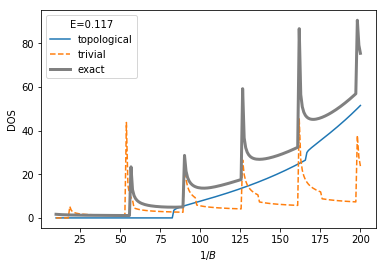

In [15]:
plot(1/Bran,4*DOS_topB,label='topological')
plot(1/Bran,2*DOS_triB,'--',label='trivial')
plot(1/spectr_exactB[:,0],spectr_exactB[:,1],label='exact',color='gray',lw=3)
legend(title='E=0.117')
xlabel('$1/B$')
ylabel('DOS');


In [16]:
DOS_topB2=[]
DOS_triB2=[]
e=0.3
Bran=1/linspace(10,200,200)
for B in tqdm.tqdm_notebook(Bran):
    dat=[]
    if e<1.:
        for n in range(1,70):
            try:
                # bisect seems to do the job here 
                # we just have to keep away from 
                # the boundary between the two regions
                val=bisect(ftop,0,sqrt(1-e)-1e-6,args=(e,n,B))               
                dat.append(abs(dostop(val,e)))
            except:
                pass
    DOS_topB2.append(sum(dat))
    dat=[]
    for n in range(70):
        try:
            # here root proved to be a better alternative
            # we need to be carefull since we have 
            # potentially two states at a given energy
            val=root(ftri,3,args=(e,n,B))
            if val['success']:
                dat.append(abs(dostri(val.x,e)))
                
            if n>0:
                val=root(ftri,sqrt(1-e)+1e-2,args=(e,n,B))
                if val['success']:
                    dat.append(abs(dostri(val.x,e)))
                

        except:
            pass
    DOS_triB2.append(sum(dat))

DOS_topB2=array(DOS_topB2)
DOS_triB2=array(DOS_triB2)


HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

In [17]:
# This bit runs for 1 h 40 mins the output is in the datafile if you do not want to rerun it..
#datB=[]
#e=0.3
#for B in tqdm.tqdm_notebook(Bran):
 
#    va,ve=eig(makeEB(e,B).toarray())
#    vg=[]
#    for i in range(len(va)):
#        vvee=ve[:,i]
#        vvaa=va[i]       
#        vg.append(dot(conj(vvee),-2*sqrt(vvaa)*curr*vvee))
#    vg=array(vg)
#    idx=(abs(imag(va))<1e-10)*(real(va)>0)   
#    datB.append(dict(E=e,B=B,va=va,vg=vg,dos=sum(1/abs(vg[idx]))))

# Dump data and meta data in output file
#with open('data/exact_B_scan_E_0p300', 'wb') as handle:
#    pickle.dump(datB , handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
with open('data/exact_B_scan_E_0p300','br') as file:
        datB=pickle.load(file)
spectr_exactB2= array([[d['B'],d['dos']] for d in datB ])

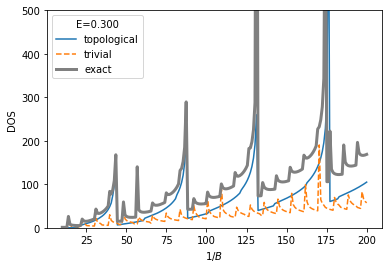

In [19]:
plot(1/Bran,4*DOS_topB2,label='topological')
plot(1/Bran,2*DOS_triB2,'--',label='trivial')
plot(1/spectr_exactB2[:,0],spectr_exactB2[:,1],label='exact',color='gray',lw=3)
legend(title='E=0.300')
ylim(0,500)

xlabel('$1/B$')
ylabel('DOS');